In [2]:
# Installazione delle dipendenze
!pip install pennylane

# Importazioni necessarie
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from sklearn.model_selection import train_test_split

# Montaggio di Google Drive
drive.mount('/content/drive')

# Definizione dei percorsi e variabili
SAVE_PATH = "/content/drive/My Drive/QML/"
PREPROCESS = False          # Se False, salta il processo quantistico e carica i dati da SAVE_PATH

# Impostazione del seed per la riproducibilità
np.random.seed(0)
tf.random.set_seed(0)

# Caricamento delle immagini
image_folder_path = '/content/drive/My Drive/brain_tumor_dataset'
data = tf.keras.utils.image_dataset_from_directory(image_folder_path)

def load_images_labels(data):
    images_np, labels_np = [], []
    for images, labels in data:
        images_np.append(images.numpy())
        labels_np.append(labels.numpy())
    return np.concatenate(images_np), np.concatenate(labels_np)

images_np, labels_np = load_images_labels(data)

# Suddivisione dei dati in train, test e val
#train_images, test_images, train_labels, test_labels = train_test_split(images_np, labels_np, test_size=0.1, random_state=42)
#train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Funzione per la conversione in scala di grigi
def rgb_to_gray(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0 for img in images])

# Conversione delle immagini
images = rgb_to_gray(images_np)

# Aggiunta di una dimensione extra per i canali della convoluzione
images = images[..., np.newaxis]

Mounted at /content/drive
Found 253 files belonging to 2 classes.


In [3]:
kernel_size = 2
n_layers = 1
shape = qml.StronglyEntanglingLayers.shape(n_layers, kernel_size**2)
rand_params = np.random.uniform(high=2 * np.pi, size=shape)
dev = qml.device("default.qubit", wires=kernel_size**2)
@qml.qnode(dev)
def circuit(phi):
    # Encoding of kernel_size classical input values
    for j in range(kernel_size**2):
        qml.RY(np.pi * phi[j], wires=j)

    # quantum circuit
    qml.StronglyEntanglingLayers(weights=rand_params, wires=range(kernel_size**2))
    # Measurement producing kernel_size classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(kernel_size**2)]

In [ ]:
def sliding_window(image, kernel_size):
    rows, cols, _ = image.shape
    for i in range(0, rows - kernel_size + 1, kernel_size):
        for j in range(0, cols - kernel_size + 1, kernel_size):
            yield i, j, [
                image[i + di, j + dj, 0] for di in range(kernel_size) for dj in range(kernel_size)
            ]

def quanv(image):
    out = np.zeros((128, 128 , 4))  # Output dimension changed to for a 3x3 kernel
    for i, j, window_data in sliding_window(image, kernel_size):
        q_results = circuit(window_data)
        for c in range(kernel_size**2):
            out[i // kernel_size, j // kernel_size, c] = q_results[c]

    return out

In [ ]:
if PREPROCESS == True:
    q_images = []
    print("Quantum pre-processing of all images:")
    for idx, img in enumerate(images):
        print(idx)
        q_images.append(quanv(img))
    q_images = np.asarray(q_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_images2K1L(SEL).npy", q_images)


# Load pre-processed images
q_images = np.load(SAVE_PATH + "q_images2K1L(SEL).npy")


In [ ]:
print(rand_params.shape)

(1, 4, 3)


In [ ]:
print(qml.draw(circuit, expansion_strategy="device")([0,0,0,0,0,0,0,0,0]))

0: ──RY(0.00)──Rot(3.72,5.30,5.39)─╭●───────╭X─┤  <Z>
1: ──RY(0.00)──Rot(5.32,3.92,2.42)─╰X─╭●────│──┤  <Z>
2: ──RY(0.00)──Rot(1.87,0.36,1.71)────╰X─╭●─│──┤  <Z>
3: ──RY(0.00)──Rot(3.00,5.10,3.02)───────╰X─╰●─┤  <Z>


In [4]:
def draw_circuit_with_params(phi):
    drawer = qml.draw(circuit, expansion_strategy="device")
    circuit_diagram = drawer(phi)
    # Annotate the diagram with np.pi * phi[j]
    for j in range(kernel_size**2):
        circuit_diagram = circuit_diagram.replace(f"RY({np.pi * phi[j]:.2f})", f"RY(np.pi * phi[{j}])")
    return circuit_diagram

# Test the circuit and draw it
phi = np.array([0, 0.5, 1, 1.5])
print(draw_circuit_with_params(phi))

0: ──RY(np.pi * phi[0])──Rot(3.72,5.30,5.39)─╭●───────╭X─┤  <Z>
1: ──RY(np.pi * phi[1])──Rot(5.32,3.92,2.42)─╰X─╭●────│──┤  <Z>
2: ──RY(np.pi * phi[2])──Rot(1.87,0.36,1.71)────╰X─╭●─│──┤  <Z>
3: ──RY(np.pi * phi[3])──Rot(3.00,5.10,3.02)───────╰X─╰●─┤  <Z>


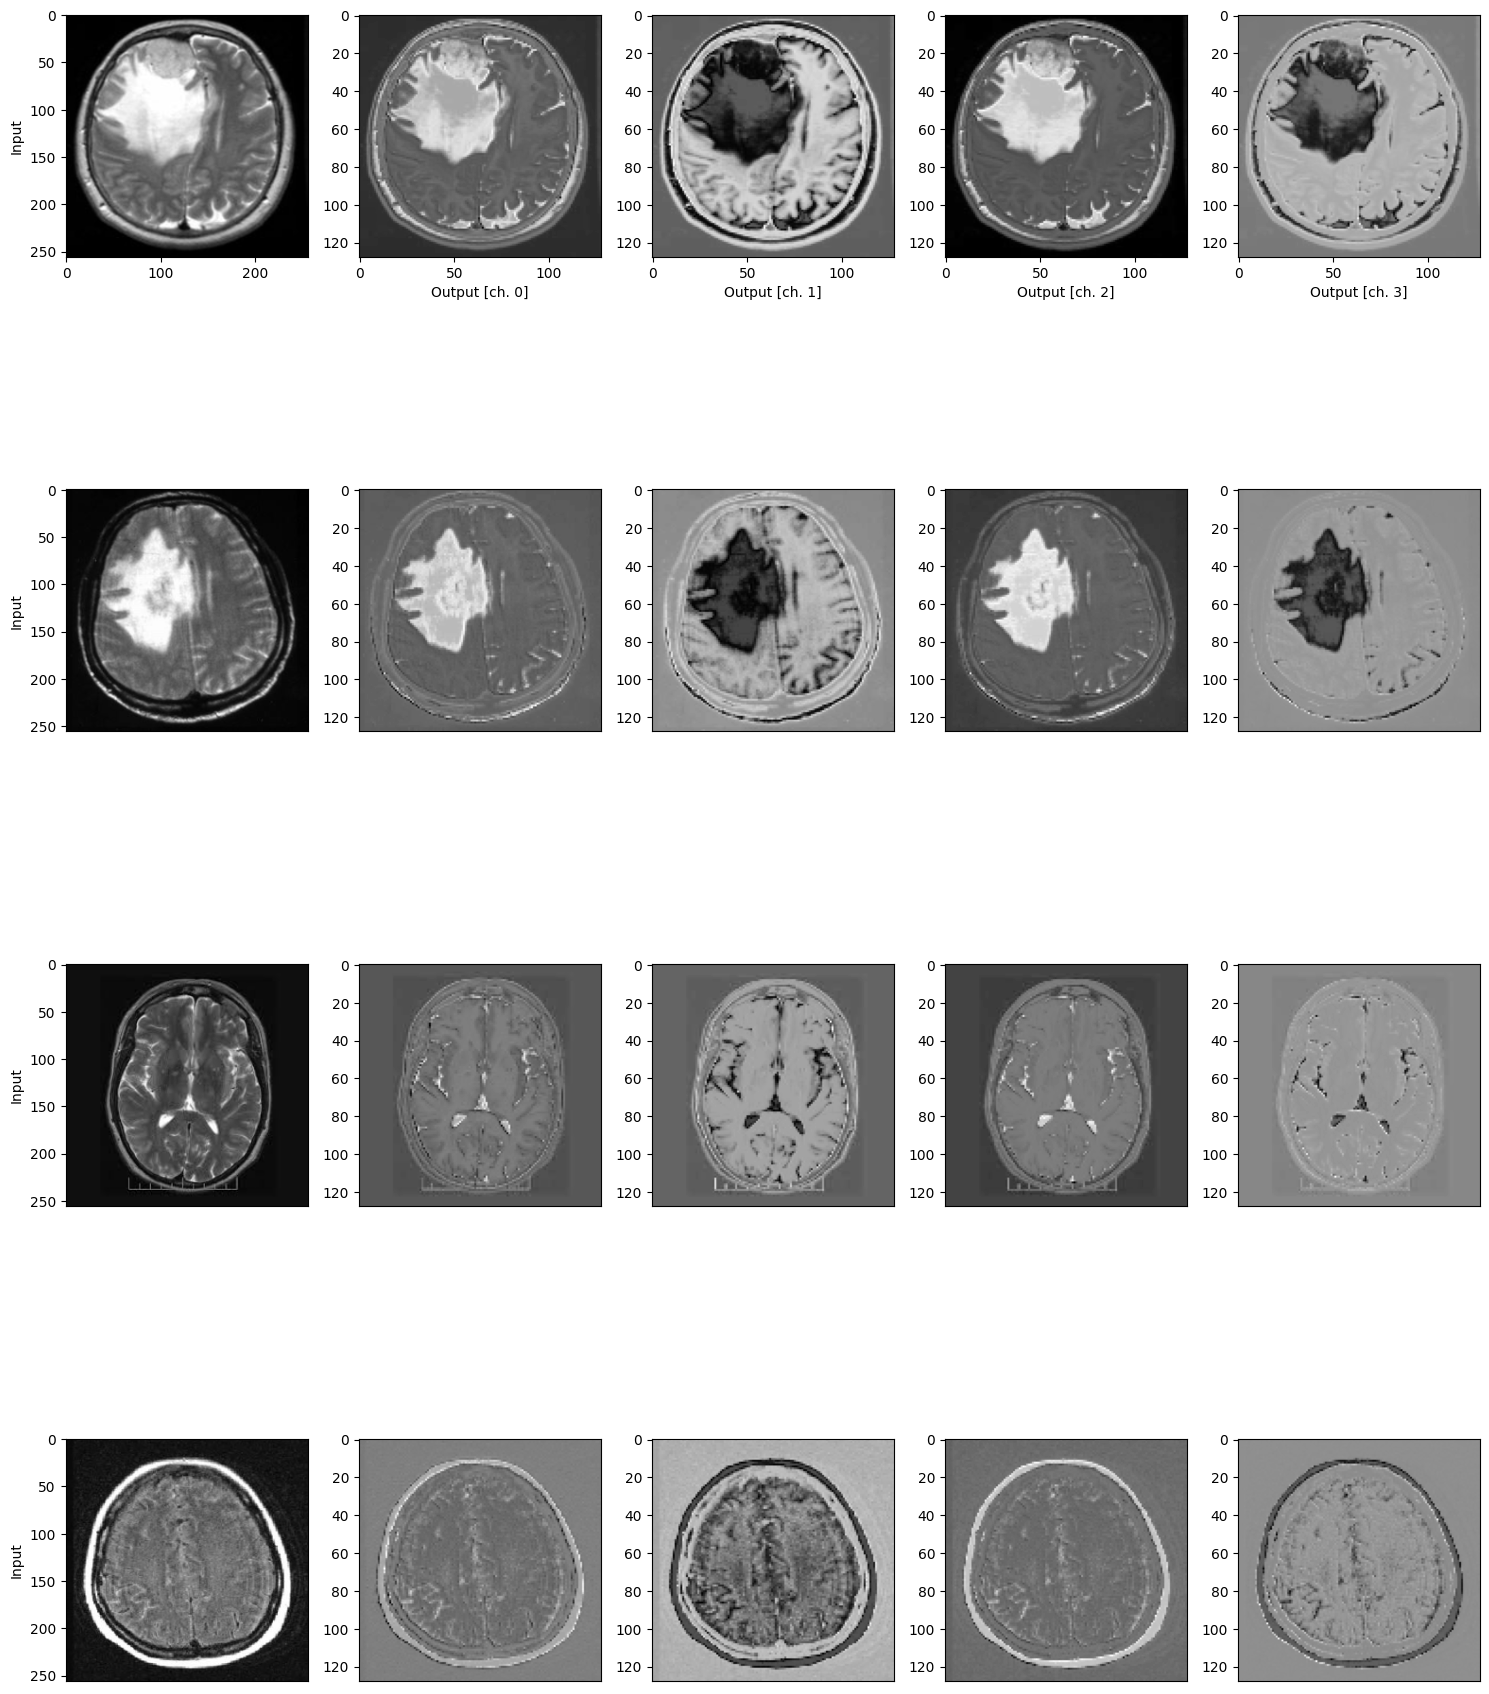

In [ ]:
import matplotlib.pyplot as plt

n_samples = 4
n_channels = 4

fig, axes = plt.subplots(n_samples, 1 + n_channels, figsize=(15, 20))  # Aumenta le dimensioni della figura

for k in range(n_samples):
    axes[k, 0].set_ylabel("Input")
    if k != 0:
        axes[k, 0].xaxis.set_visible(False)  # Nascondi gli assi x
    axes[k, 0].imshow(images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[k, c + 1].set_xlabel("Output [ch. {}]".format(c))  # Etichetta x
        if k != 0:
            axes[k, c + 1].xaxis.set_visible(False)  # Nascondi gli assi x
        axes[k, c + 1].imshow(q_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_images.shape

(253, 128, 128, 4)

In [ ]:
n_epochs = 20
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

kernel_size = 3

model = Sequential()

model.add(Conv2D(32, (kernel_size, kernel_size), activation='relu', input_shape=(128, 128, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      1184      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(q_images, labels_np, test_size=0.1, random_state=42)

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
q_model = model

q_history = q_model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/20
6/6 - 16s - loss: 0.8805 - accuracy: 0.4862 - val_loss: 0.6380 - val_accuracy: 0.6522 - 16s/epoch - 3s/step
Epoch 2/20
6/6 - 11s - loss: 0.5994 - accuracy: 0.6519 - val_loss: 0.5120 - val_accuracy: 0.8261 - 11s/epoch - 2s/step
Epoch 3/20
6/6 - 13s - loss: 0.5358 - accuracy: 0.7514 - val_loss: 0.5093 - val_accuracy: 0.7609 - 13s/epoch - 2s/step
Epoch 4/20
6/6 - 8s - loss: 0.4852 - accuracy: 0.7680 - val_loss: 0.4892 - val_accuracy: 0.8261 - 8s/epoch - 1s/step
Epoch 5/20
6/6 - 6s - loss: 0.4527 - accuracy: 0.7956 - val_loss: 0.4795 - val_accuracy: 0.8261 - 6s/epoch - 1s/step
Epoch 6/20
6/6 - 7s - loss: 0.3892 - accuracy: 0.8177 - val_loss: 0.4801 - val_accuracy: 0.8696 - 7s/epoch - 1s/step
Epoch 7/20
6/6 - 10s - loss: 0.3647 - accuracy: 0.8287 - val_loss: 0.4832 - val_accuracy: 0.8696 - 10s/epoch - 2s/step
Epoch 8/20
6/6 - 8s - loss: 0.2741 - accuracy: 0.8950 - val_loss: 0.4774 - val_accuracy: 0.8261 - 8s/epoch - 1s/step
Epoch 9/20
6/6 - 6s - loss: 0.2595 - accuracy: 0.9006 - 

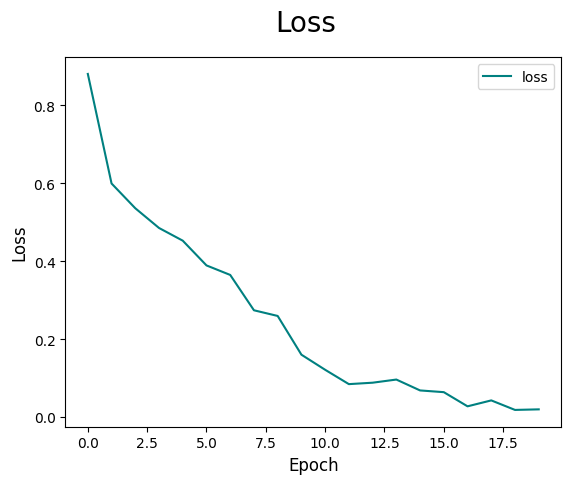

In [ ]:
fig = plt.figure()
plt.plot(q_history.history['loss'], color='teal', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcolo delle predizioni del modello
y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(int)  # Considera una soglia di 0.5 per la classificazione binaria

# Calcolo di precision, recall e f1-score
precision = precision_score(test_labels, y_pred_binary)
recall = recall_score(test_labels, y_pred_binary)
f1 = f1_score(test_labels, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

1/1 [==============================] - 0s 307ms/step
Precision: 0.8
Recall: 0.9411764705882353
F1-score: 0.8648648648648648


In [ ]:
incorrect_indices = []
for i in range(len(test_labels)):
  if(test_labels[i] != y_pred_binary[i][0]):
    incorrect_indices.append(i)
print(incorrect_indices)

[12, 13, 18, 19, 25]
